In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import classification_report, f1_score, make_scorer

In [105]:
rs = 42
mi = 10000

sns.set_style("whitegrid")

models = [DecisionTreeClassifier(random_state=rs), 
          KNeighborsClassifier(), 
          GaussianNB(), 
          LinearSVC(random_state=rs, max_iter=mi), 
          SVC(random_state=rs, max_iter=mi), 
          LogisticRegression(random_state=rs, max_iter=mi)]

train_path = './data/Cleaned_Train_Dataset.csv'
test_path = './data/Cleaned_Test_Dataset.csv'

In [106]:
def make_mi_scores(X, y):
    discrete_features = X.dtypes == int
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features, random_state=rs)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores):
    plt.figure(dpi=100, figsize=(8, 10))
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")
    plt.show()
    
def evaluate_for_models(models, X, y):
    results = pd.DataFrame({'Model': [], 
                            'ScoreMean(F1)': [], 'Score Standard Deviation(F1)': [], 
                            'ScoreMean': [], 'Score Standard Deviation': []})
    for model in models:
        score_f1 = cross_val_score(model, X, y, 
                                scoring='f1')
        score = cross_val_score(model, X, y)
        new_result = {'Model': model.__class__.__name__, 
                      'ScoreMean(F1)': score_f1.mean(), 'Score Standard Deviation(F1)': score_f1.std(), 
                      'ScoreMean': score.mean(), 'Score Standard Deviation': score.std()}
        results = results.append(new_result, ignore_index=True)
    return results.sort_values(by=['ScoreMean(F1)', 'Score Standard Deviation(F1)', 
                                   'ScoreMean', 'Score Standard Deviation'], ascending=False)

def classification_report_with_accuracy_score(y_true, y_pred):
    print(classification_report(y_true, y_pred))
    return f1_score(y_true, y_pred)

def encode(dataframe, is_train=True):
    data = dataframe.copy()
    encoded_data = pd.get_dummies(data, columns=['location_code'])
    if is_train:
        encoded_data['Churn'] = encoded_data['Churn'].map({'Yes': 1, 'No': 0})
    for col in ['intertiol_plan', 'voice_mail_plan']:
        encoded_data[col] = encoded_data[col].map({'yes': 1, 'no': 0})
    return encoded_data

def add_features(dataframe):
    
    global lr_day
    global lr_eve
    global lr_nyt
    
    data = dataframe.copy()
    
    data['total_min'] = data['total_day_min'] + data['total_eve_min'] + data['total_night_minutes'] + data['total_intl_minutes']

    try:
        data['expected_total_day_charge'] = lr_day.predict(data[['total_day_min']])
        data['expected_total_eve_charge'] = lr_eve.predict(data[['total_eve_min']])
        data['expected_total_nyt_charge'] = lr_nyt.predict(data[['total_night_minutes']])
    except NameError:
        lr_day = LinearRegression()
        lr_eve = LinearRegression()
        lr_nyt = LinearRegression()

        lr_day.fit(data[['total_day_min']], data['total_day_charge'])
        lr_eve.fit(data[['total_eve_min']], data['total_eve_charge'])
        lr_nyt.fit(data[['total_night_minutes']], data['total_night_charge'])

        data['expected_total_day_charge'] = lr_day.predict(data[['total_day_min']])
        data['expected_total_eve_charge'] = lr_eve.predict(data[['total_eve_min']])
        data['expected_total_nyt_charge'] = lr_nyt.predict(data[['total_night_minutes']])
    
    data['error_total_day_charge'] = abs(data['expected_total_day_charge'] - data['total_day_charge'])
    data['error_total_eve_charge'] = abs(data['expected_total_eve_charge'] - data['total_eve_charge'])
    data['error_total_nyt_charge'] = abs(data['expected_total_nyt_charge'] - data['total_night_charge'])
    
    return data

In [107]:
train = pd.read_csv(train_path, index_col=0)
train.head()

,account_length,location_code,intertiol_plan,voice_mail_plan,number_vm_messages,total_day_min,total_day_calls,total_day_charge,total_eve_min,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,Churn
customer_id,,,,,,,,,,,,,,,,,,,
1001,15.0,452,no,no,0.0,121.1,130.0,20.59,216.0,86.0,18.36,235.1,33.0,10.58,16.1,5.0,4.35,2.0,No
1002,105.0,452,no,no,0.0,259.3,96.0,44.08,175.2,97.0,14.89,222.4,36.0,10.01,12.0,5.0,3.24,3.0,No
1003,97.0,452,no,yes,32.0,183.4,94.0,31.18,269.1,120.0,22.87,203.5,38.0,9.16,6.7,4.0,1.81,5.0,No
1004,121.0,445,no,yes,35.0,68.7,95.0,11.68,209.2,69.0,17.78,197.4,42.0,8.88,11.4,4.0,3.08,1.0,No
1005,98.0,452,no,yes,22.0,278.3,89.0,47.31,93.4,143.0,7.94,107.6,42.0,4.84,9.7,5.0,2.62,0.0,No


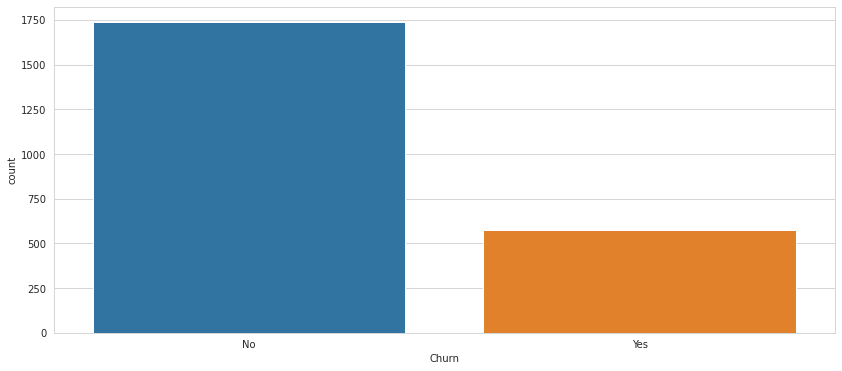

In [108]:
plt.figure(figsize=(14, 6))
sns.countplot(data=train, x='Churn')
plt.savefig('imbalanced.jpg', dpi=100)
plt.show()

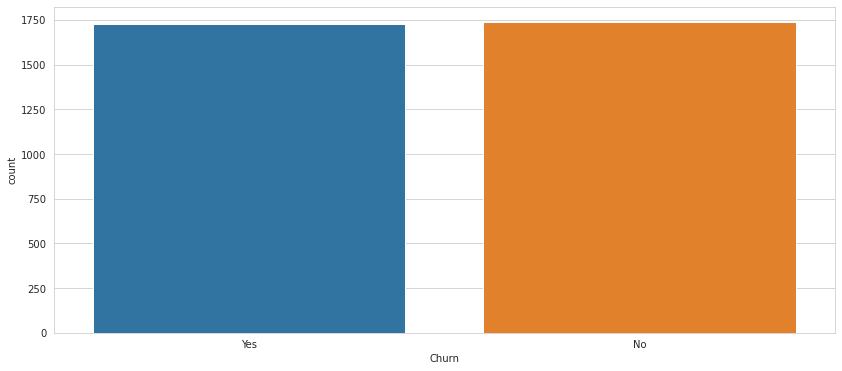

,account_length,location_code,intertiol_plan,voice_mail_plan,number_vm_messages,total_day_min,total_day_calls,total_day_charge,total_eve_min,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,Churn
0,111.0,547,no,no,0.0,179.9,97.0,29.07,106.8,58.0,9.74,209.7,89.0,9.62,10.5,5.0,2.84,4.0,Yes
1,97.0,445,no,no,0.0,277.1,88.0,44.94,206.1,106.0,16.09,232.3,75.0,10.41,8.9,5.0,2.40,0.0,Yes
2,114.0,547,no,no,0.0,172.0,145.0,29.24,276.4,101.0,23.49,193.7,100.0,8.72,10.1,9.0,2.73,1.0,No
3,60.0,445,yes,yes,29.0,279.9,107.0,43.20,218.8,91.0,19.34,121.1,83.0,4.86,14.0,13.0,3.78,0.0,Yes
4,64.0,547,no,yes,40.0,210.0,116.0,35.70,232.7,89.0,19.78,168.8,94.0,7.60,5.9,4.0,1.59,8.0,Yes


In [109]:
churned_train = train.loc[train.Churn=='Yes']
oversampled_train = train.append(churned_train, ignore_index=True)
oversampled_train = oversampled_train.append(churned_train, ignore_index=True).sample(frac=1, random_state=rs, ignore_index=True)
plt.figure(figsize=(14, 6))
sns.countplot(data=oversampled_train, x='Churn')
plt.savefig('balanced.jpg', dpi=100)
plt.show()
oversampled_train.head()

In [110]:
fadded_train = add_features(oversampled_train)

In [111]:
encoded_train = encode(fadded_train)

In [112]:
X = encoded_train.drop(columns=['Churn'])
y = encoded_train.Churn

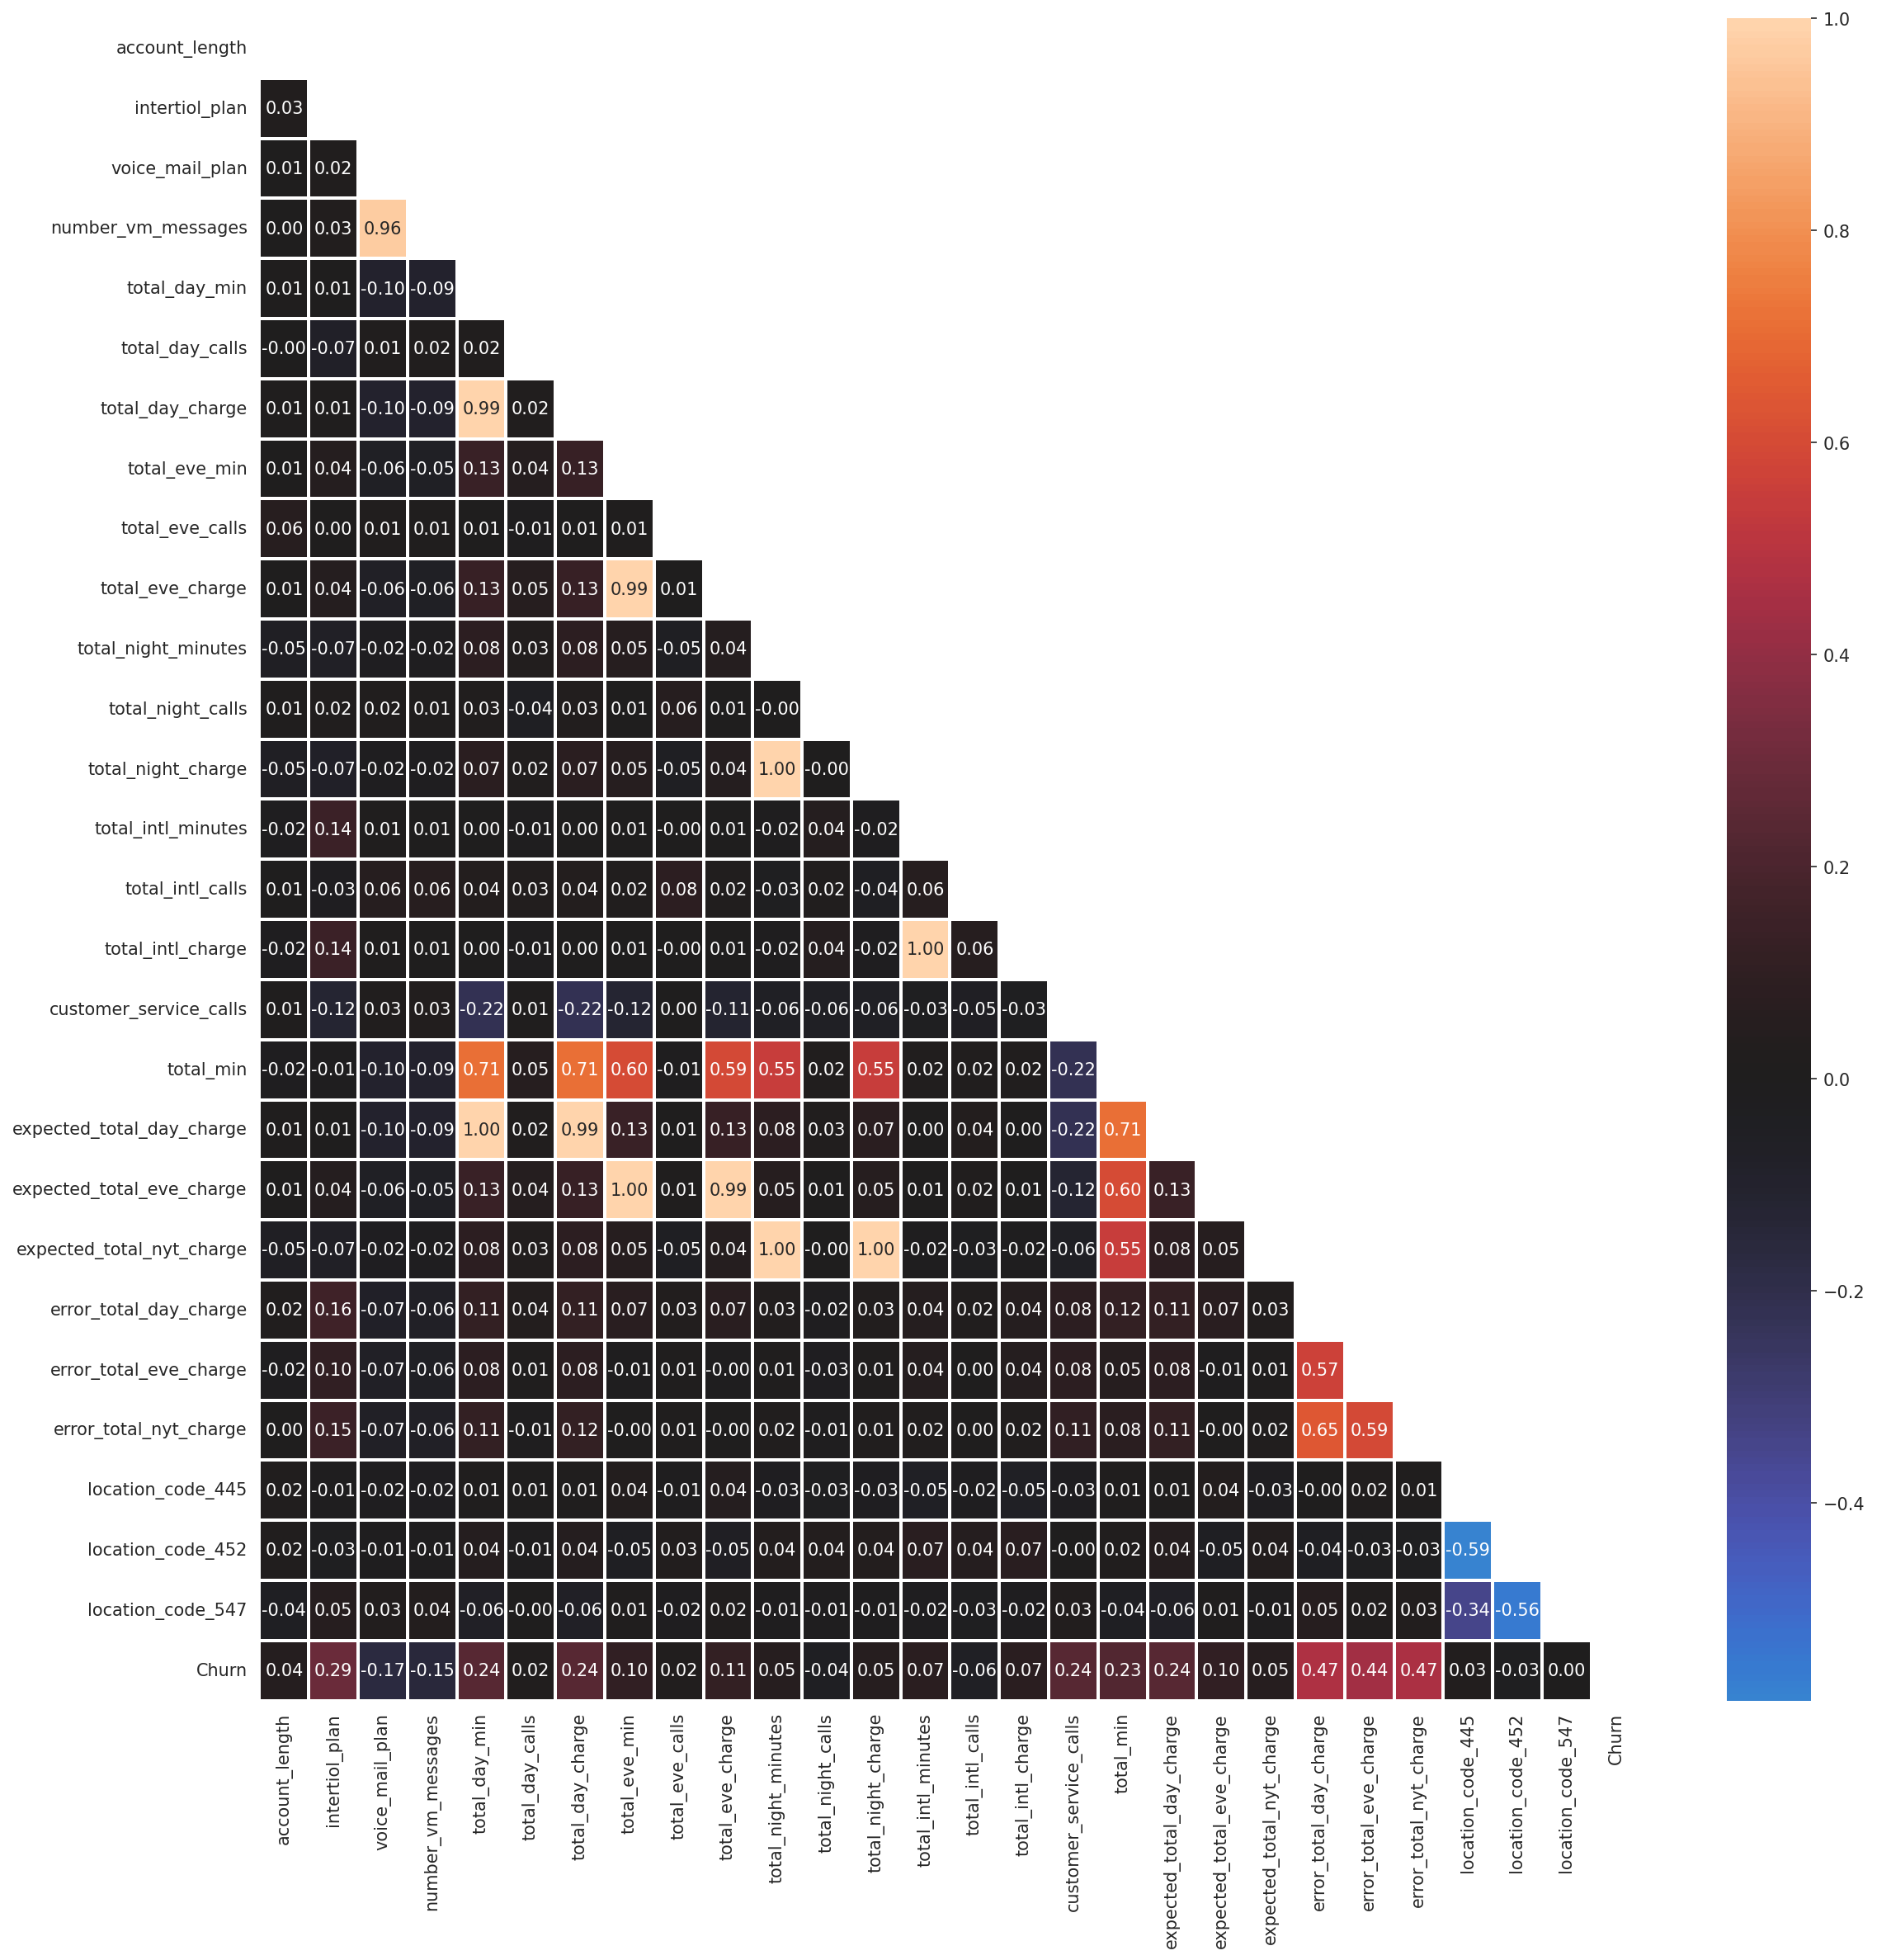

In [113]:
data = X.copy()
data['Churn'] = y
corr = data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(18,18), dpi=150)
sns.heatmap(corr, mask=mask,  center=0, linewidths=1, annot=True, fmt=".2f")
plt.show()

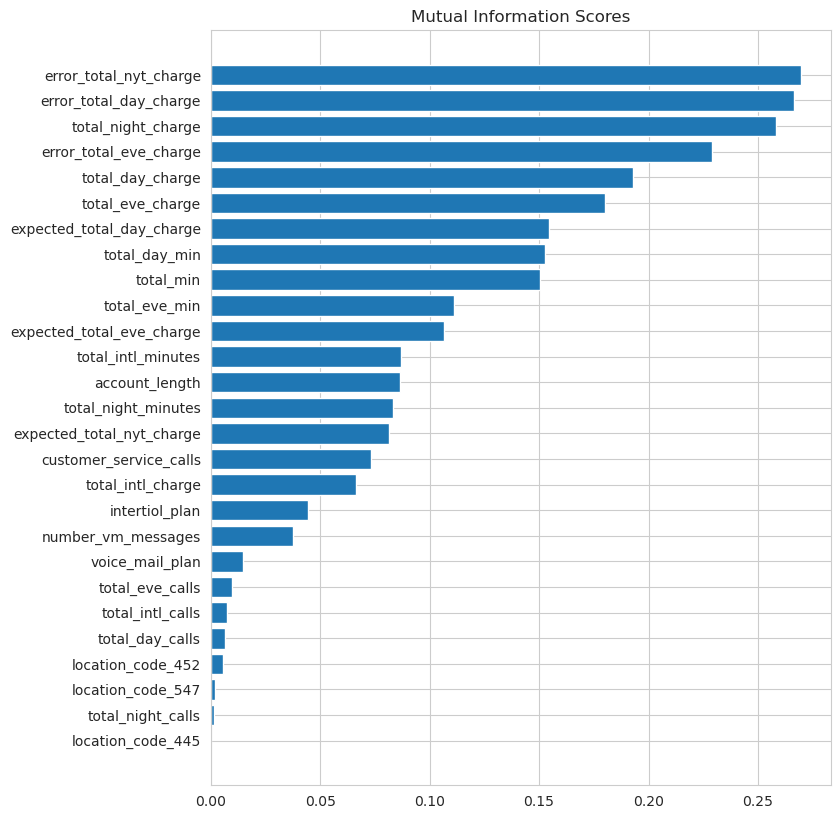

In [114]:
scores = make_mi_scores(X, y)
plot_mi_scores(scores)

In [12]:
evaluate_for_models(models, X, y)

/home/kajanan/ProgramFiles/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/kajanan/ProgramFiles/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/kajanan/ProgramFiles/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/kajanan/ProgramFiles/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/kajanan/ProgramFiles/anaconda3/lib/python3.9/site-packages

,Model,ScoreMean(F1),Score Standard Deviation(F1),ScoreMean,Score Standard Deviation
0,DecisionTreeClassifier,0.970073,0.004975,0.969381,0.005283
1,KNeighborsClassifier,0.837872,0.007510,0.813981,0.008860
5,LogisticRegression,0.830532,0.005424,0.839400,0.003436
2,GaussianNB,0.712258,0.022474,0.775851,0.014261
3,LinearSVC,0.694023,0.030608,0.693828,0.080762
4,SVC,0.592401,0.024580,0.680250,0.013316


In [13]:
std_scaler = StandardScaler()
scaled_X = pd.DataFrame(std_scaler.fit_transform(X), columns=X.columns)

In [14]:
evaluate_for_models(models, scaled_X, y)

,Model,ScoreMean(F1),Score Standard Deviation(F1),ScoreMean,Score Standard Deviation
0,DecisionTreeClassifier,0.970073,0.004975,0.969381,0.005283
4,SVC,0.928926,0.005338,0.929519,0.005145
1,KNeighborsClassifier,0.872372,0.007417,0.872037,0.006542
3,LinearSVC,0.837776,0.004867,0.846330,0.003913
5,LogisticRegression,0.828342,0.005549,0.837955,0.004013
2,GaussianNB,0.711799,0.021882,0.775562,0.013884


In [15]:
models = [DecisionTreeClassifier(random_state=rs), 
          RandomForestClassifier(random_state=rs)]

In [16]:
evaluate_for_models(models, X, y)

,Model,ScoreMean(F1),Score Standard Deviation(F1),ScoreMean,Score Standard Deviation
1,RandomForestClassifier,0.991926,0.004876,0.991913,0.004885
0,DecisionTreeClassifier,0.970073,0.004975,0.969381,0.005283


#### RandomForestClassifier  Tuning

In [72]:
random_grid = {'bootstrap': [True, False], 
               'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 
               'max_features': ['auto', 'sqrt'], 
               'min_samples_leaf': [1, 2, 4], 
               'min_samples_split': [2, 5, 10],
               'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

rf_rscv = RandomizedSearchCV(RandomForestClassifier(random_state=rs), 
                             param_distributions = random_grid, 
                             n_iter = 100, cv = 5, verbose=2, random_state=rs, n_jobs = -1, scoring='f1')
rf_rscv.fit(X, y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=2000; total time=  11.8s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1400; total time=   9.5s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1200; total time=   8.0s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time=   7.9s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   5.7s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   5.6s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimato

[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=2000; total time=  12.0s
[CV] END bootstrap=True, max_depth=None, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1400; total time=   9.9s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1600; total time=  11.4s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1800; total time=  12.7s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time=   5.7s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1800; total time=  17.3s
[CV] END bootstrap=False, max_depth=90, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=2000; total time=  18.6s
[CV] END bootstrap=True, max_depth

[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1200; total time=   8.0s
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1200; total time=   8.1s
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.6s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1200; total time=   8.1s
[CV] END bootstrap=False, max_depth=70, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=800; total time=   7.8s
[CV] END bootstrap=True, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=1800; total time=  12.7s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=1000; total time=   9.3s
[CV] END bootstrap=False, max_depth=80, 

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, scoring='f1', verbose=2)

In [74]:
rf_rscv_result = pd.DataFrame(rf_rscv.cv_results_)
rf_rscv_result[['param_bootstrap', 'param_max_depth', 'param_max_features', 'param_min_samples_leaf', 'param_min_samples_split', 'param_n_estimators', 'mean_test_score', 'std_test_score', 'rank_test_score']].sort_values(by=['rank_test_score']).head()

,param_bootstrap,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,mean_test_score,std_test_score,rank_test_score
97,False,60,auto,1,2,1000,0.992780,0.003767,1
57,False,90,auto,1,5,2000,0.992207,0.003833,2
52,False,None,auto,1,5,2000,0.992207,0.003833,2
75,True,None,auto,1,2,200,0.991922,0.004143,4
3,True,50,auto,1,2,200,0.991922,0.004143,4


In [75]:
params = {'bootstrap': [False], 
          'max_depth': [55, 60, 65], 
          'max_features': ['auto'], 
          'min_samples_leaf': [1], 
          'min_samples_split': [2], 
          'n_estimators': [1000, 1200, 1400, 1600, 2000]}

rf_gscv = GridSearchCV(RandomForestClassifier(random_state=rs), 
                       params, scoring='f1')
rf_gscv.fit(X, y)

GridSearchCV(estimator=RandomForestClassifier(random_state=42),
             param_grid={'bootstrap': [False], 'max_depth': [55, 60, 65],
                         'max_features': ['auto'], 'min_samples_leaf': [1],
                         'min_samples_split': [2, 5],
                         'n_estimators': [1000, 1200, 1400, 1600, 2000]},
             scoring='f1')

In [76]:
rf_gscv_result = pd.DataFrame(rf_gscv.cv_results_)
rf_gscv_result[['param_bootstrap', 'param_max_depth', 'param_max_features', 'param_min_samples_leaf', 'param_min_samples_split', 'param_n_estimators', 'mean_test_score', 'std_test_score', 'rank_test_score']].sort_values(by=['rank_test_score']).head()

,param_bootstrap,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,mean_test_score,std_test_score,rank_test_score
1,False,55,auto,1,2,1200,0.993067,0.003585,1
2,False,55,auto,1,2,1400,0.993067,0.003585,1
3,False,55,auto,1,2,1600,0.993067,0.003585,1
23,False,65,auto,1,2,1600,0.993067,0.003585,1
22,False,65,auto,1,2,1400,0.993067,0.003585,1


In [77]:
rf_gscv.best_params_

{'bootstrap': False,
 'max_depth': 55,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1200}

In [17]:
models = [RandomForestClassifier(random_state=rs), 
          RandomForestClassifier(random_state=rs, bootstrap=False, max_depth=55, 
                                 max_features='auto', min_samples_leaf=1, min_samples_split=2, n_estimators=1200)]

In [18]:
evaluate_for_models(models, X, y)

,Model,ScoreMean(F1),Score Standard Deviation(F1),ScoreMean,Score Standard Deviation
1,RandomForestClassifier,0.993067,0.003585,0.993067,0.003586
0,RandomForestClassifier,0.991926,0.004876,0.991913,0.004885


In [19]:
cross_val_score(models[1], X=X, y=y, 
                scoring=make_scorer(classification_report_with_accuracy_score))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       348
           1       0.99      0.99      0.99       345

    accuracy                           0.99       693
   macro avg       0.99      0.99      0.99       693
weighted avg       0.99      0.99      0.99       693

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       348
           1       0.99      1.00      1.00       345

    accuracy                           1.00       693
   macro avg       1.00      1.00      1.00       693
weighted avg       1.00      1.00      1.00       693

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       347
           1       0.99      1.00      0.99       345

    accuracy                           0.99       692
   macro avg       0.99      0.99      0.99       692
weighted avg       0.99      0.99      0.99       692

              preci

array([0.99130435, 0.995671  , 0.99423631, 0.98701299, 0.99710983])

#### Final Model

In [31]:
final_model = models[1]
final_model.fit(X, y)

RandomForestClassifier(bootstrap=False, max_depth=55, n_estimators=1200,
                       random_state=42)

#### Test

In [32]:
test = pd.read_csv(test_path, index_col=0)
test.head()

,account_length,location_code,intertiol_plan,voice_mail_plan,number_vm_messages,total_day_min,total_day_calls,total_day_charge,total_eve_min,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls
customer_id,,,,,,,,,,,,,,,,,,
3322,91,445.0,yes,no,0.0,258.4,112.0,42.89,190.0,93,14.47,158.6,105.0,7.09,12.1,3.0,3.27,2.0
3323,113,445.0,no,yes,20.0,155.8,81.0,28.83,168.5,62,13.73,275.5,105.0,12.22,8.7,3.0,2.35,5.0
3324,122,445.0,no,no,0.0,237.2,137.0,40.30,263.8,134,22.76,251.3,105.0,10.81,8.8,4.0,2.38,1.0
3325,103,445.0,no,no,0.0,133.6,117.0,23.60,156.1,130,13.37,207.2,105.0,9.95,10.4,7.0,2.81,8.0
3326,111,452.0,no,no,0.0,115.6,120.0,24.54,211.1,66,18.79,140.9,105.0,5.76,12.7,1.0,3.43,4.0


In [33]:
fadded_test = add_features(test)

In [34]:
encoded_test = encode(fadded_test, False)

In [35]:
encoded_test['Churn'] = final_model.predict(encoded_test)

In [36]:
test_prediction = encoded_test[['Churn']].reset_index()
test_prediction['Churn'] = test_prediction['Churn'].map({1:'Yes', 0:'No'})
test_prediction

,customer_id,Churn
0,3322,Yes
1,3323,Yes
2,3324,Yes
3,3325,Yes
4,3326,Yes
...,...,...
1495,4817,Yes
1496,4818,Yes
1497,4819,No
1498,4820,No


In [37]:
test_prediction.to_csv('./data/prediction/test_prediction.csv', index=False)